In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
# fastai/imagenet-fast/cifar10/models/ repo
from imagenet_fast_cifar_models.wideresnet import wrn_22
from torchvision import transforms, datasets

torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10")

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [14]:
# PATH = Path("data/cifar10_tmp")
PATH = Path("data/cifar10")

In [15]:
def get_loaders(bs, num_workers):
    traindir = str(PATH/'train')
    valdir   = str(PATH/'test')
    tfms     = [transforms.ToTensor(),
#                 transforms.Normalize(*stats)]
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    aug_tfms = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ] + tfms)
    
    train_dataset = datasets.ImageFolder(traindir, aug_tfms)
    val_dataset   = datasets.ImageFolder(valdir, transforms.Compose(tfms))
    aug_dataset   = datasets.ImageFolder(valdir, aug_tfms)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=False)
    val_loader   = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=False)
    aug_loader   = torch.utils.data.DataLoader(
        aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=False)
    
    return train_loader, val_loader, aug_loader

In [16]:
def get_data(bs, num_workers):
    trn_dl, val_dl, aug_dl = get_loaders(bs, num_workers)
    data = ModelData(PATH, trn_dl, val_dl)
    data.aug_dl = aug_dl
    data.sz = 32
    return data

def get_learner(arch, bs):
    learn = ConvLearner.from_model_data(arch.cuda(), get_data(bs, num_cpus()))
    learn.crit = nn.CrossEntropyLoss()
    learn.metrics = [accuracy]
    return learn

def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

100%|█████████▉| 3111/3125 [03:44<00:01, 13.86it/s, loss=8.2] 

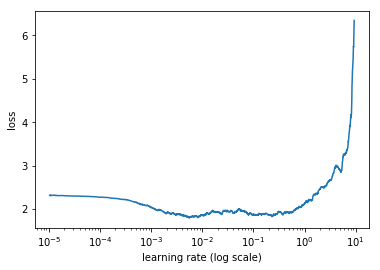

In [17]:
learner = get_learner(wrn_22(), 16)
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

epoch      trn_loss   val_loss   accuracy                 
    0      2.23063    24041.498281 0.1       


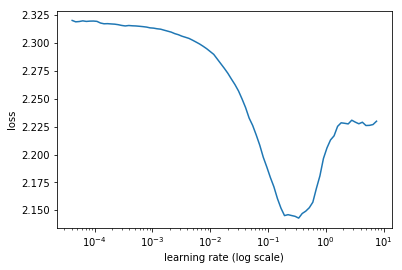

In [19]:
learner = get_learner(wrn_22(), 512)
learner.lr_find(wds=1e-4)
learner.sched.plot(n_skip_end=1)

In [20]:
torch.__version__

'0.3.1.post2'

In [22]:
%time learner.fit(1.5, 1, wds=1e-4, cycle_len=30, use_clr_beta=(15, 10, 0.95, 0.85));

epoch      trn_loss   val_loss   accuracy                 
    0      1.610085   1.626076   0.4395    
    1      1.223421   1.317524   0.5633                   
    2      0.940387   2.038279   0.4745                    
    3      0.762601   1.217451   0.6398                    
    4      0.654419   0.961155   0.7008                    
    5      0.565586   0.639681   0.7832                    
    6      0.50137    0.599894   0.7996                    
    7      0.460526   0.626692   0.7843                    
    8      0.425721   0.603371   0.7926                    
    9      0.393813   0.893688   0.749                     
    10     0.374892   0.699583   0.7713                    
    11     0.353577   0.630499   0.8066                    
    12     0.345882   0.576161   0.805                     
    13     0.327537   0.719755   0.781                     
    14     0.313273   0.639451   0.7996                    
    15     0.292252   0.559769   0.832                    

[array([0.23512]), 0.9350999992370606]

In [24]:
get_TTA_accuracy(learner)

0.9423